# Data visualisation
## 0. Intro
Data visualisation is a walkthrow the TDSC dataset. It's recommended to analyse the dataset before starting investigaion of possible models to solve the problem. before we know look for the proper model, we have to undrestand the data we are working on and its challenges.

This notebook is created to visualise the data and extract requred datafrom the original dataset which is suitable for the classification task.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import datasets
from tqdm.notebook import tqdm

import utils

In [2]:
dataset_sagittal = datasets.Tumors(path="./data/tdsc/tumors_3d/z")
dataset_coronal = datasets.Tumors(path="./data/tdsc/tumors_3d/y")
dataset_axial = datasets.Tumors(path="./data/tdsc/tumors_3d/x")

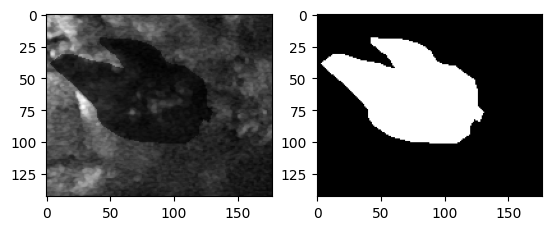

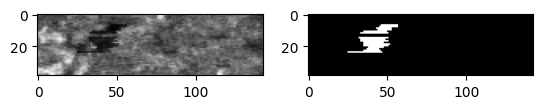

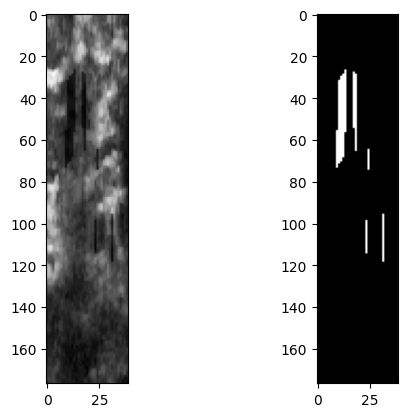

In [3]:
v,m,y = dataset_sagittal[0]
d = 15

g = m[:,:,d]
x = v[:,:,d] - v[:,:,d] * g * 0.5

plt.figure()
plt.subplot(1,2,1)
plt.imshow(x, cmap="gray")
plt.subplot(1,2,2)
plt.imshow(g, cmap="gray")
plt.show()

v,m,y = dataset_coronal[0]

g = m[:,:,d]
x = v[:,:,d] - v[:,:,d] * g * 0.5

plt.figure()
plt.subplot(1,2,1)
plt.imshow(x, cmap="gray")
plt.subplot(1,2,2)
plt.imshow(g, cmap="gray")
plt.show()

v,m,y = dataset_axial[0]

g = m[:,:,d]
x = v[:,:,d] - v[:,:,d] * g * 0.5

plt.figure()
plt.subplot(1,2,1)
plt.imshow(x, cmap="gray")
plt.subplot(1,2,2)
plt.imshow(g, cmap="gray")
plt.show()

In [3]:
bbxs = []

loop = tqdm(dataset)

for _, mask, __ in loop:
    
    depth_l, depth_h = 1000, 0
    
    for depth in range(mask.shape[2]):
        if(mask[:,:,depth].max() == 1):
            depth_l = min(depth_l, depth)
            depth_h = max(depth_h, depth)
    item_bbxs = []
    for d in range(depth_l, depth_h+1):
        y = mask[:,:,d]
        y,x,h,w = utils.image.find_bbx(y)
        item_bbxs = item_bbxs + [(x,y,w,h,d)]
        
    bbxs = bbxs + [item_bbxs]

new_bbxs = bbxs
print(bbxs)
    

  0%|          | 0/100 [00:00<?, ?it/s]

[[(370, 94, 19, 21, 232), (362, 86, 28, 29, 233), (357, 44, 39, 95, 234), (355, 43, 45, 94, 235), (350, 35, 52, 104, 236), (347, 24, 56, 116, 237), (347, 22, 58, 118, 238), (337, 21, 69, 137, 239), (336, 18, 69, 137, 240), (335, 18, 70, 138, 241), (333, 17, 74, 191, 242), (334, 17, 73, 194, 243), (320, 14, 88, 197, 244), (320, 15, 88, 201, 245), (319, 16, 87, 204, 246), (324, 16, 81, 205, 247), (323, 15, 80, 212, 248), (325, 16, 78, 213, 249), (325, 17, 82, 215, 250), (330, 15, 79, 217, 251), (329, 19, 68, 208, 252), (330, 19, 76, 219, 253), (332, 21, 102, 207, 254), (331, 19, 81, 212, 255), (329, 19, 72, 211, 256), (332, 25, 67, 207, 257), (336, 27, 59, 211, 258), (344, 42, 66, 198, 259), (340, 43, 78, 196, 260), (336, 122, 83, 149, 261), (334, 127, 86, 123, 262), (340, 127, 77, 101, 263), (335, 130, 87, 88, 264), (334, 186, 27, 34, 265), (336, 188, 15, 34, 266), (334, 191, 17, 27, 267)], [(675, 84, 20, 27, 104), (668, 77, 27, 38, 105), (661, 78, 36, 67, 106), (668, 74, 54, 60, 107), 

In [5]:


new_bbxs = []

for vol_bbxs in bbxs:
    item_bbxs = []
    for bbx in vol_bbxs:
        item_bbxs = item_bbxs + [utils.image.find_squer_from_rect(bbx)]
    new_bbxs = new_bbxs + [item_bbxs]
print(new_bbxs)

[[(369, 94, 21, 21, 232), (362, 86, 29, 29, 233), (329, 44, 95, 95, 234), (330, 43, 94, 94, 235), (324, 35, 104, 104, 236), (317, 24, 116, 116, 237), (317, 22, 118, 118, 238), (303, 21, 137, 137, 239), (302, 18, 137, 137, 240), (301, 18, 138, 138, 241), (275, 17, 191, 191, 242), (273, 17, 194, 194, 243), (266, 14, 197, 197, 244), (264, 15, 201, 201, 245), (260, 16, 204, 204, 246), (262, 16, 205, 205, 247), (257, 15, 212, 212, 248), (258, 16, 213, 213, 249), (259, 17, 215, 215, 250), (261, 15, 217, 217, 251), (259, 19, 208, 208, 252), (259, 19, 219, 219, 253), (280, 21, 207, 207, 254), (265, 19, 212, 212, 255), (260, 19, 211, 211, 256), (262, 25, 207, 207, 257), (260, 27, 211, 211, 258), (278, 42, 198, 198, 259), (281, 43, 196, 196, 260), (303, 122, 149, 149, 261), (316, 127, 123, 123, 262), (328, 127, 101, 101, 263), (334, 130, 88, 88, 264), (330, 186, 34, 34, 265), (326, 188, 34, 34, 266), (329, 191, 27, 27, 267)], [(672, 84, 27, 27, 104), (662, 77, 38, 38, 105), (646, 78, 67, 67, 106

## Creating classification dataset

In [5]:
path = "./data/tdsc/classification"
cnt = 0
padding = 20
for index, bbxs in enumerate(tqdm(new_bbxs)):
    volume, mask, label = dataset[index]
    mask = mask*255
    for bbx in bbxs:
        x, y, w, h, d = bbx
        x, y = max(x-padding, 0), max(y-padding, 0)
        w, h = w + padding*2, h + padding*2
        sli = volume[x:x+w, y:y+h, d]
        msk = mask[x:x+w, y:y+h, d]
        cv2.imwrite(f"{path}/data/{label}/{cnt}.png", sli)
        cv2.imwrite(f"{path}/mask/{label}/{cnt}.png", msk)
        cnt = cnt + 1

  0%|          | 0/100 [00:00<?, ?it/s]

In [8]:
classification_dataset = datasets.TDSCForClassification()

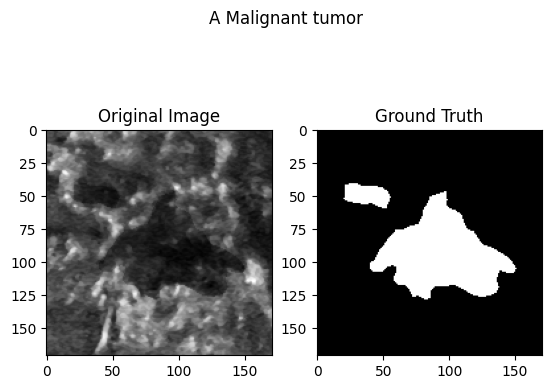

In [18]:
x,y,l = classification_dataset[500]
x = x-x*y*0.2
tumor_type = "Malignant" if l == 0 else "Benign"
plt.figure()
plt.suptitle(f"A {tumor_type} tumor")
plt.subplot(1,2,1)
plt.imshow(x, cmap='gray')
plt.title("Original Image")
plt.subplot(1,2,2)
plt.imshow(y, cmap='gray')
plt.title("Ground Truth")
plt.show()

In [10]:
tumor_sizes = []
malignant_sizes = []
benign_sizes = []

for _, mask, label in classification_dataset:
    tumor_sizes = tumor_sizes + [mask.sum()]
    if label == 0:
        malignant_sizes = malignant_sizes + [mask.sum()]
    else:
        benign_sizes = benign_sizes + [mask.sum()]

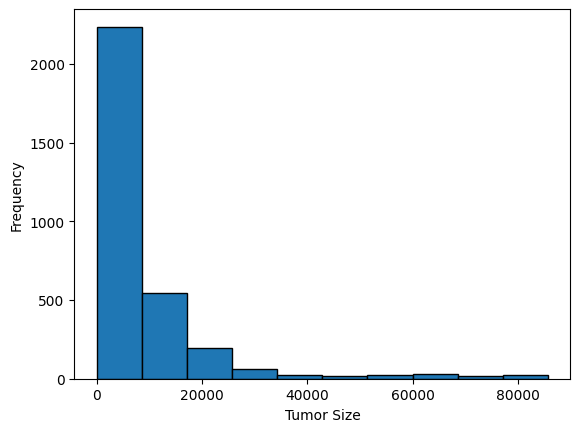

In [11]:
plt.hist(tumor_sizes, bins=10, edgecolor='black')
plt.xlabel('Tumor Size')
plt.ylabel('Frequency')
plt.show()

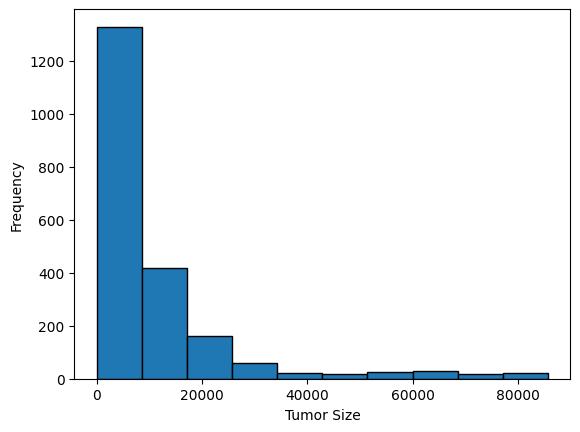

In [12]:
plt.hist(malignant_sizes, bins=10, edgecolor='black')
plt.xlabel('Tumor Size')
plt.ylabel('Frequency')
plt.show()

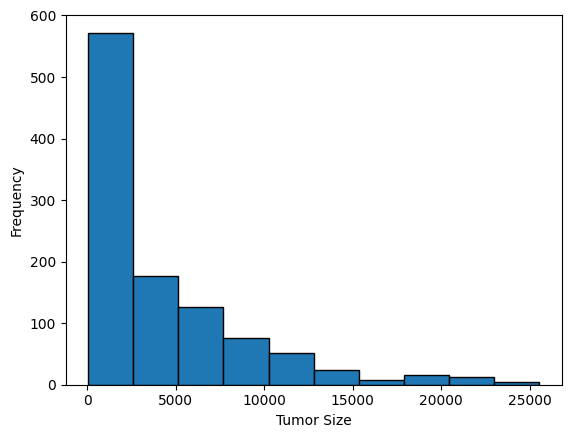

In [13]:
plt.hist(benign_sizes, bins=10, edgecolor='black')
plt.xlabel('Tumor Size')
plt.ylabel('Frequency')
plt.show()

## 2. Creating detection dataset

In [6]:
tdsc = datasets.TDSC()

In [11]:
def has_intersection_with_tumor(slice, center, dims):
    patch = slice[center[0]-dims[0]//2:center[0]+dims[0]//2, center[1]-dims[1]:center[1]+dims[1]]
    return patch.sum() > 0

def pick_random_center(limits, borders):
    cx = np.random.randint(borders[0], limits[0] - borders[0])
    cy = np.random.randint(borders[1], limits[1] - borders[1])
    cz = np.random.randint(0, limits[2])
    return cx,cy, cz

path_to_positive = "./data/tdsc/detection/1"
path_to_negative = "./data/tdsc/detection/0"

cnt = 0

for index, bbxs in enumerate(tqdm(new_bbxs)):
    volume, mask, label = tdsc[index]
    for bbx in bbxs:
        w, h, d = volume.shape
        x, y, width, height, depth = bbx
        # Drop small slices
        if width < 80:
            continue
        center = pick_random_center((w,h,d), (width//2, height//2))
        sli = mask[:,:,center[2]]
        while has_intersection_with_tumor(sli, center, (width, height)):
            center = pick_random_center((w, h, d), (width//2, height//2))
            sli = mask[:,:,center[2]]

        posetive = volume[x:x+width, y:y+height, depth]
        negative = volume[center[0]-width//2 : center[0]+width//2, center[1]-width//2 : center[1]+width//2 , center[2]]
        cv2.imwrite(f"{path_to_positive}/{cnt}.png", posetive)
        cv2.imwrite(f"{path_to_negative}/{cnt}.png", negative)
        cnt += 1


            

  0%|          | 0/100 [00:00<?, ?it/s]

In [7]:
x,m,y = tdsc[50]
bbxs = new_bbxs[59]
print(x.shape, m.shape, y)
print(bbxs)

(865, 608, 330) (865, 608, 330) 1
[(417, 204, 24, 24, 164), (418, 204, 24, 24, 165), (413, 201, 27, 27, 166), (410, 202, 24, 24, 167), (405, 207, 31, 31, 168), (402, 211, 26, 26, 169), (398, 219, 31, 31, 170), (400, 213, 27, 27, 171), (398, 203, 31, 31, 172), (395, 202, 35, 35, 173), (391, 190, 45, 45, 174), (369, 160, 78, 78, 175), (376, 173, 67, 67, 176), (373, 171, 70, 70, 177), (375, 171, 61, 61, 178), (375, 171, 61, 61, 179), (381, 174, 59, 59, 180), (386, 187, 76, 76, 181), (385, 194, 65, 65, 182), (381, 188, 67, 67, 183), (371, 183, 74, 74, 184), (374, 183, 69, 69, 185), (379, 181, 65, 65, 186), (379, 181, 65, 65, 187), (390, 195, 57, 57, 188), (389, 183, 65, 65, 189), (366, 152, 99, 99, 190), (345, 133, 148, 148, 191), (337, 122, 156, 156, 192), (343, 119, 156, 156, 193), (348, 124, 154, 154, 194), (345, 125, 149, 149, 195), (354, 122, 143, 143, 196), (356, 138, 122, 122, 197), (356, 138, 122, 122, 198), (350, 135, 129, 129, 199), (342, 131, 143, 143, 200), (352, 133, 139, 139,